In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import argparse
import sys

In [2]:
def load_data(filepath):
    """    
    Parameters:
    filepath (cvs): training data.

    Returns:
    x (np.array) : inputs, attributes.
    y (np.array) : outputs.

    """
    X, y = [], []
    with open(filepath, 'r') as file:
        for line in file:
            x, y_ = line.strip().split(',')
            X.append(float(x))
            y.append(float(y_))
    return np.array(X), np.array(y)


def load_sol_data(filepath):
    """    
    Parameters:
    filepath (cvs): solution data.

    Returns:
    m (int) : polynomial degree.
    w (np.array) : weights.

    """
    with open(filepath, 'r') as file:
        m = int(file.readline().strip())
        w = []
        for line in file:
            w_ = float(line.strip())
            w.append(w_)
    return m, np.array(w)



def create_phi(x, degree):
    """
    This function creates a matrix of x values raised to powers.
    :param x: numpy array of input data
    :param degree: degree of the polynomial
    :return: matrix of x values raised to powers
    """
    matrix = np.zeros((len(x), degree + 1))
    for i in range(len(x)):
        for j in range(degree + 1):
            matrix[i][j] = x[i] ** j
    return matrix


def regularized_linear_regression(phi, t, lambda_):
    """
    Find the best fitting regularized weights for a linear model using equation 3.28 from PRML.

    Parameters:
    X : Training data input. (trainPath)
    y : Training data output. (modelOutput)
    lambda_ : Regularization parameter.

    Returns:
    w : Best regularized weights.
    """
    i, size = phi.shape
    phi_t = phi.transpose()
    phit_phi = np.matmul(phi_t, phi)
    id = np.identity(size)
    phit_phi += lambda_ * id
    phit_phi_inv = np.linalg.inv(phit_phi)
    w_reg = np.matmul(phit_phi_inv, phi_t)
    w = np.matmul(w_reg, t)
    return w


def sweep(X, m, lambda_):
    """
    Sweep up to max polynomial (m).

    Parameters:
    X : Training data input. (trainPath)
    m : Given polynomial.
    lambda_ : Regularization parameter.

    Returns:
    weight_list : List of best regularized weights per polynomial.
    """
    weight_list = []
    for i in range(m+1):
        phi_m = create_phi(X, i)
        weight = regularized_linear_regression(phi_m, t, 0)
        weight_list.append(weight)
    return weight_list


def prediction(X, phi, w):
    """
    Compute prediction for polynomial regression.

    Parameters:
    X (np.array) : Training data input.
    phi (matrix) : Matrix of x values raised to powers.
    w (np.array) : Best regularized weights.

    Returns:
    y(X, phi, w) : prediction.
    """

    return np.dot(phi, w)


def small_phi(phi, r):
    return phi[r]


def errorfunction(y, t):
    error = 0.0
    for i in range(len(y)):
        error += (y[i]-t[i])**2

    return 1/2*error

def split_data(x, t, ratio):
    # Shuffle data
    shuffle_index = np.random.permutation(len(x))
    x = x[shuffle_index]
    t = t[shuffle_index]
    
    # Split data into training and test sets
    split_index = int(len(x) * ratio)
    x_train = x[:split_index]
    t_train = t[:split_index]
    x_test = x[split_index:]
    t_test = t[split_index:]
    
    return x_train, t_train, x_test, t_test

def rms(error, N):
    return np.sqrt((2*error)/N)


In [34]:
def kfold_cv_k(x, t, M, k):
    """
    K-Fold Cross Validation
    
    Parameters:
    x (np.array): inputs, attributes.
    t (np.array): outputs.
    M (int): polynomial degree.
    k (int): number of folds.
    
    Returns:
    avg_error (float): average root mean squared error.
    """
    data = np.concatenate((x.reshape(-1,1), t.reshape(-1,1)), axis=1)
    # folds = np.array_split(data, k)
    error_list = []
    for i in range(k):
        validation_indices = [j for j in range(len(x)) if j % k == i]
        validation_fold = data[validation_indices]
        print(validation_fold)
        # training_indices = [j for j in range(len(x)) if j % k != i]
        # training_folds = data[training_indices]
        # training_folds = np.concatenate([folds[j] for j in range(k) if j != i])
        # x_train, t_train = training_folds[:,0], training_folds[:,1]
        x_val, t_val = validation_fold[:,0], validation_fold[:,1]
        phi_val = create_phi(x_val, M)
        w_test = regularized_linear_regression(phi_val, t_val, 0)
        y_test = prediction(x_val, phi_val, w_test)
        error = errorfunction(y_test, t_val)
        error_list.append(error)
    avg_error = np.mean(error_list)
    
    return avg_error, error_list


def solve_curve_fitting_k(x, t, M, k):

    phi = np.array(create_phi(x, M))
    w = regularized_linear_regression(phi, t, 0.0)
    y = prediction(x, phi, w)    
    error = errorfunction(y, t)
    rms = np.sqrt(2*error/len(x))
    avg_error, errorlist = kfold_cv_k(x, t, M, k)
    k_rms = np.sqrt(2*avg_error/len(x))

    return w, y, error, rms, avg_error, k_rms, errorlist
    # return rms

def plot_tt_k(x, t, m, ratio, k):
    x_train, t_train, x_test, t_test = split_data(x, t, ratio)
    M = np.arange(0, m)
    train_rms = []
    test_rms = []
    for i in M:
        rms_train = solve_curve_fitting_k(x_train, t_train, i, k)
        train_rms.append(rms_train[5])
        rms_test = solve_curve_fitting_k(x_test, t_test, i, k)
        test_rms.append(rms_test[5])
        
    plt.plot(M, train_rms, '-o', label='Train RMS')
    plt.plot(M, test_rms, '-o', label='Test RMS')
    plt.xlabel('M (degree)')
    plt.ylabel('RMS')
    plt.legend()
    plt.show()
    return  train_rms, test_rms

In [35]:
input = load_data("sampleData/X")
X, t = input
M =30
k = 5
ratio = 8/10
fit = solve_curve_fitting_k(X, t, M,k)
w = fit[0]
y = fit[1]
error = fit[2]
rms = fit[3]
avg_error = fit[4]
k_rms = fit[5]
errorlist = fit[6]

[[-1.        0.010685]
 [-0.949749  0.229034]
 [-0.899497  0.377399]
 [-0.849246  0.428747]
 [-0.798995  0.648058]
 [-0.748744  0.727263]
 [-0.698492  0.628645]
 [-0.648241  0.694526]
 [-0.59799   0.795685]
 [-0.547739  0.673567]
 [-0.497487  0.623841]
 [-0.447236  0.655378]
 [-0.396985  0.556071]
 [-0.346734  0.536701]
 [-0.296482  0.46831 ]
 [-0.246231  0.477993]
 [-0.19598   0.425216]
 [-0.145729  0.389001]
 [-0.095477  0.338913]
 [-0.045226  0.347234]
 [ 0.005025  0.320054]
 [ 0.055276  0.300411]
 [ 0.105528  0.319456]
 [ 0.155779  0.300808]
 [ 0.20603   0.334125]
 [ 0.256281  0.308418]
 [ 0.306533  0.348341]
 [ 0.356784  0.427834]
 [ 0.407035  0.463859]
 [ 0.457286  0.491929]
 [ 0.507538  0.626295]
 [ 0.557789  0.740364]
 [ 0.60804   0.776154]
 [ 0.658291  0.920504]
 [ 0.708543  1.059474]
 [ 0.758794  1.273766]
 [ 0.809045  1.445815]
 [ 0.859296  1.684903]
 [ 0.909548  1.997083]
 [ 0.959799  2.321307]]
[[-0.98995   0.063526]
 [-0.939698  0.245568]
 [-0.889447  0.456378]
 [-0.83919

In [33]:
errorlist

[0.7872768290367781,
 2.5439113354688487,
 0.32718075417624876,
 8.427192700260768,
 594.6306826292501]

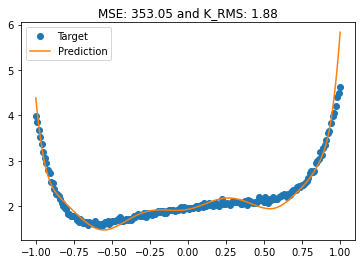

Coefficients: [ 1.93071174e+00  6.55857643e-01  4.71418122e+00 -2.44132560e+00
 -6.12212948e+01  2.70100843e+01  2.07832491e+02 -3.08749628e+02
  5.70308210e+02  2.39703118e+03 -9.39980481e+03 -1.15287004e+04
  4.82753316e+04  3.37133530e+04 -1.39185307e+05 -5.67201204e+04
  2.40913586e+05  4.14111935e+04 -2.36582986e+05  2.26493179e+04
  8.37114167e+04 -6.78368097e+04  8.23553236e+04  3.98707906e+04
 -1.23759928e+05  9.45662064e+03  7.12578520e+04 -1.86677607e+04
 -2.11192722e+04  5.53933315e+03  2.81533163e+03]
Mean Squared Error: 353.05434092093094
Root-Mean-Squared: 1.8789740310098246


In [25]:
plt.plot(X, t, 'o', label='Target')
plt.plot(X, y, '-', label='Prediction')
plt.legend()
plt.title('MSE: {:.2f}'.format(avg_error) + ' and K_RMS: {:.2f}'.format(k_rms))
plt.show()

    
print('Coefficients:', w)
# print('Predicted values:', y)
print('Mean Squared Error:', avg_error)
print('Root-Mean-Squared:', k_rms)

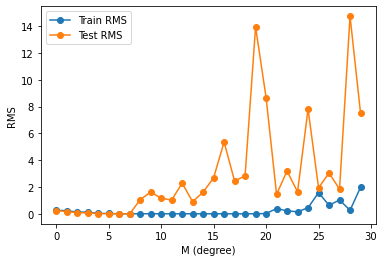

In [27]:
train_rms, test_rms = plot_tt_k(X, t, M, ratio,k)


In [80]:
def when_diverges(train, test):
    for i in range(5, len(train)):
        if train[i] > train[i-1] and train[i] > test[i]:
            return i
        if test[i] > test[i-1] and test[i] > train[i]:
            return i
        # if train[i] > train[i-1] != (test[i] > test[i-1]):
        #     return i
    return None


In [81]:
index = when_diverges(train_rms, test_rms)
index - 1

20